# Mounting Google Drive

In [1]:
##### before running it, make sure you don't have lots of big files in your google drive
##### otherwise it's going to take too long to finish running it before giving the TIMEOUT error
##### also save the train_controls, train_patients, val_controls, val_patients to your drive and
##### create a "train" folder with train_controls, train_patients in it, and 
##### a "val" folder with val_controls, val_patients in it.
##### change the train_dir and val_dir in the next cell to the dir of your train and val folder
##### e.g. my train and val folder are saved in the "deep learning" dir

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Loading Train, Val, and Test Data Using Keras ImageDataGenerator

In [2]:
train_dir = "/gdrive/My Drive/new_dataset/trainProbMaps/"
val_dir = "/gdrive/My Drive/new_dataset/valProbMaps/"
test_dir = "/gdrive/My Drive/new_dataset/testProbMaps/"

img_width = 600
img_height = 450
batch_size = 5
channels = 3
epochs = 50
nb_train_samples = 408
nb_validation_samples = 150
nb_test_samples = 200

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)             
valid_datagen = ImageDataGenerator(rescale=1./255)    
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')   

validation_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary') #weight toward one class or another

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

#Keras takes care of generating labels if the directory structure matches above!
label_mapT = train_generator.class_indices
print(label_mapT)

label_mapV = validation_generator.class_indices
print(label_mapV)

label_mapTe = test_generator.class_indices
print(label_mapTe)

for data_batch, labels_batch in train_generator:
    print ('data batch shape:', data_batch.shape)
    #print(data_batch)
    print('labels batch shape:', labels_batch.shape)
    #print(labels_batch)
    break

Using TensorFlow backend.


Found 410 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
{'controls': 0, 'patients': 1}
{'controls': 0, 'patients': 1}
{'controls': 0, 'patients': 1}
data batch shape: (5, 600, 450, 3)
labels batch shape: (5,)


# Building the Model Architecture & Training the Model

In [3]:
import numpy as np 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Softmax, Flatten, Dense, BatchNormalization 
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import regularizers
import tensorflow as tf
from keras.models import Sequential

from keras.callbacks import TensorBoard

#from keras.layers import Input, Dense
from keras.models import Model

input_shape = (img_width, img_height, channels)
model = Sequential()
model.add(Conv2D(32,(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples / batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples / batch_size,
    shuffle=True) # // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 598, 448, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 598, 448, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 299, 224, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 297, 222, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 297, 222, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 109, 64)      18496     
__________

# Testing on Untouched Subset of Atlantis Patients and Controls

In [4]:
#TEST Accuracy on fraction from same group results in quite high accuracy but could get higher...
#print(train_generator.filenames)
#print(validation_generator.filenames)

nb_test_samples = 200

result = model.evaluate_generator(test_generator, steps=nb_test_samples / batch_size)
print(result)

predictions = model.predict_generator(test_generator, steps=nb_test_samples / batch_size)
print(np.round(predictions))
print(len(predictions))
img_path = "/gdrive/My Drive/new_dataset/testProbMaps/patients/24215.png"

from keras.preprocessing import image                             
import numpy as np

img = image.load_img(img_path, target_size=(img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                               


print(img_tensor.shape)
#validation_generator.classes

[2.7384236331008185, 0.8000000111758709]
[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]

# Testing on Early Glaucoma Dataset

In [5]:
#TEST Accuracy on Early Glaucoma Dataset (actually about 50% of these are classified as controls by experts 
#but were patients according to the training group criteria), so 50% accuracy make sense!!
test_dir = "/gdrive/My Drive/test/" 

img_width = 600
img_height = 450

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

nb_test_samples = 102

result = model.evaluate_generator(test_generator, steps=nb_test_samples / batch_size)
print(result)

predictions = model.predict_generator(test_generator, steps=nb_test_samples / batch_size)
print(np.round(predictions))
print(len(predictions))



Found 102 images belonging to 2 classes.
[5.551055008497571, 0.6372549143784186]
[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
102


In [6]:
print(test_generator.filenames)

['test_controls/control1.png', 'test_controls/control10.png', 'test_controls/control11.png', 'test_controls/control12.png', 'test_controls/control13.png', 'test_controls/control14.png', 'test_controls/control15.png', 'test_controls/control16.png', 'test_controls/control17.png', 'test_controls/control18.png', 'test_controls/control19.png', 'test_controls/control2.png', 'test_controls/control20.png', 'test_controls/control21.png', 'test_controls/control22.png', 'test_controls/control23.png', 'test_controls/control24.png', 'test_controls/control25.png', 'test_controls/control26.png', 'test_controls/control27.png', 'test_controls/control28.png', 'test_controls/control29.png', 'test_controls/control3.png', 'test_controls/control30.png', 'test_controls/control31.png', 'test_controls/control32.png', 'test_controls/control33.png', 'test_controls/control34.png', 'test_controls/control35.png', 'test_controls/control36.png', 'test_controls/control37.png', 'test_controls/control38.png', 'test_cont

# Visualizing Layer Activations

(1, 598, 448, 32)


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7ff99b843908>>

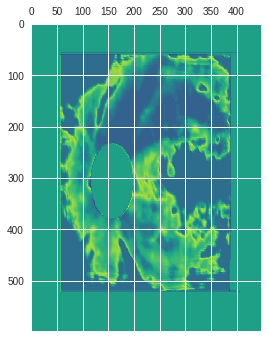

In [7]:
import matplotlib.pyplot as plt

#plt.imshow(img_tensor[0])
#plt.show()

from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

import matplotlib.pyplot as plt
plt.figure()
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

model.summary